## Multi-Layer Perceptrons (MLP) and Convolutional Neural Networks (CNNs)

Learning objectives
- Understand and implement MLP for handwritten digit recognition (MNIST)
- Learn about Neural Network components: layers, activation function, backpropagation
- Build and train a CNN for CIFAR-10 dataset
- Learn CNN components: convolution, pooling, and feature maps
- Visualize what a CNN learns and build intuition on why they're better at image recognition

In [ ]:
# first, we'll import tools/modules we need for our pytorch models

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader # easy way to deal with data

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm # nice looking progress bars
import time

In [ ]:
# check if a GPU is present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


## Load the MNIST Dataset

In [ ]:
# transform to convert image to PyTorch Tensors
transform_mnist = transforms.ToTensor()

# Load MNIST

# Download and load the training data
trainset_mnist = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform_mnist)
trainloader_mnist = DataLoader(trainset_mnist, batch_size=64, shuffle=True)

# Download and load the test data
testset_mnist = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform_mnist)
testloader_mnist = DataLoader(testset_mnist, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.39MB/s]


In [ ]:
# visualize a subset of our data
def show_images_mnist(dataloader):
  images, labels = next(iter(dataloader))
  img_grid = torchvision.utils.make_grid(images)
  np_img = img_grid.numpy()

  plt.figure(figsize=(10,7))
  plt.imshow(np.transpose(np_img, (1,2,0)))
  plt.title("A subset of MNIST digits")
  plt.axis('off')
  plt.show()

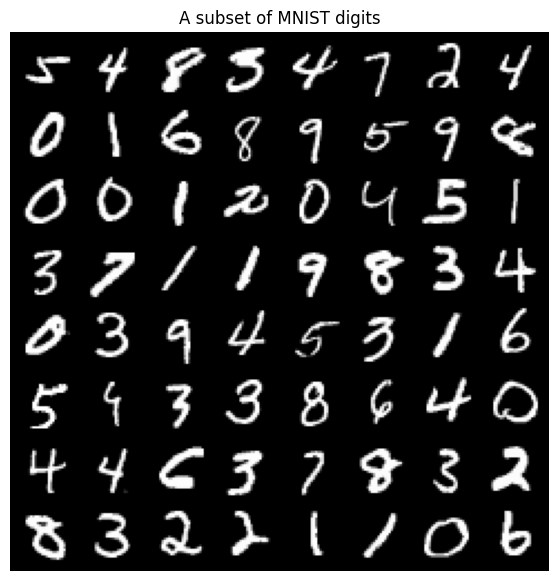

In [ ]:
show_images_mnist(trainloader_mnist)

### Build the Multu-Layer Perception (MLP) model
An MLP works on 1D data (a simple list of numbers). So, we must first **flatten** our sid image (28 x 28) into a 1D vector (784 pixels)

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()

    self.fc1 = nn.Linear(28*28, 128) # 784 -> 128
    self.fc2 = nn.Linear(128, 64) # 128 -> 64
    self.fc3 = nn.Linear(64, 10) # 64 -> 10

  def forward(self, x):
    x = x.view(-1, 28*28) # flatten the image
    x = F.relu(self.fc1(x)) # pass first hidden layer and apply ReLU
    x = F.relu(self.fc2(x)) # pass second hidden layer and apply ReLU
    x = self.fc3(x) # pass the output later, we don't need activation here, loss
    return x

In [ ]:
model_mlp_mnist = MLP().to(device)
print(model_mlp_mnist)

MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


### Training process

CONCEPTUAL CHALLENGE

1.
```optimizer.zero_grad()```
- Clear gradient from the previous iteration. We do this becase PyTorch accumlates gradients by default.

2.
```output = model(data)```
- Performs the forward pass through the network to get predictions

3. ```loss = criterion(output, target)```
- Calculates the error, or loss, between predictions and true labels.

4. ```loss.backward()```
- Computes the gradient of the loss with respect to all model parameters (weights). This is also known as backpropogation.

5. ```optimizer.step() ```
- Updates the model parameters using the computed gradients to minimize the loss.

6. What happens if we forget to call ```optimizer.step```?
The model will not progress with training.


### Train the MLP on MNIST

In [1]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp_mnist.parameters(), lr=.001)

num_epochs = 5
model_mlp_mnist.train()

for epoch in range(num_epochs):
  for images, labels in tqdm(trainloader_mnist, desc=f"Epoch {epoch+1}/{num_epochs}"):
    images, labels = images.to(device), labels.to(device)

    # Core training steps

    # 1. Zero the gradients
    optimizer.zero_grad()

    # 2. Forward pass: get models predictions
    outputs = model_mlp_mnist(images)

    # 3. Calculate the loss
    loss = criterion(outputs, labels)

    # 4. Backward pass: calculate the gradient
    loss.backward()

    # 5. Update the weights
    optimizer.step()

print(f"\nFinished training the MLP on MNIST!! YAY")

NameError: name 'nn' is not defined

### Evaluate the MLP on MNIST

Now let's see how well it performs on the test set - data set it has never seen ever

In [ ]:
model_mlp_mnist.eval() # set model ot evaluation mode

correct = 0
total = 0

with torch.no_grad():
  for images, labels in testloader_mnist:
    images, labels = images.to(device), labels.to(device)
    outputs = model_mlp_mnist(images)
    _, predicted = torch.max(outputs.data, 1) # get the index of the max log-probability
    total += labels.size(0) # -> total = total + labels.size(0)
    correct += (predicted == labels).sum().item()

  accuracy_mlp_mnist = 100 * correct / total
  print(f"Accuracy of the MLP on MNIST: {accuracy_mlp_mnist:.2f}%")

Accuracy of the MLP on MNIST: 97.37%


### 2. MLP on CIFAR-10 (more challenging)
Our MLP was really good at solving MNIST. But what happens when the images more complex and messy, like photos from the real world?

### Load and visualize CIFAR-10 dataset

CIFAR-10 contains 60,000 32x32 color images across 10 classes.

In [ ]:
# github.com/wenwei202/pytorch-examples/blob/autogrow/cifar10/get_mean_std.py

cifar_mean = (.4914, .4822, .4465)
cifar_std = (.2023, .1994, .2010)

# data augment (RandomHorizantalFlip) is technique to create more training data
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std)
])

# Load CIFAR-10 dataset
trainset_cifar = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
trainloader_cifar = DataLoader(trainset_cifar, batch_size=128, shuffle=True)

testset_cifar = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
testloader_cifar = DataLoader(testset_cifar, batch_size=128, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]


In [ ]:
# visualize the dataset
def show_images_cifar(dataloader):
  images, labels = next(iter(dataloader))
  img_grid = torchvision.utils.make_grid(images)


  # un-normalize the images to display correctly
  img_grid = img_grid.numpy().transpose((1,2,0))
  img_grid = np.array(cifar_std) * img_grid + np.array(cifar_mean)
  img_grid = np.clip(img_grid, 0, 1)

  plt.figure(figsize=(12,12))
  plt.imshow(img_grid)
  plt.title('A subset of CIFAR-10 images')
  plt.axis('off')
  plt.show()

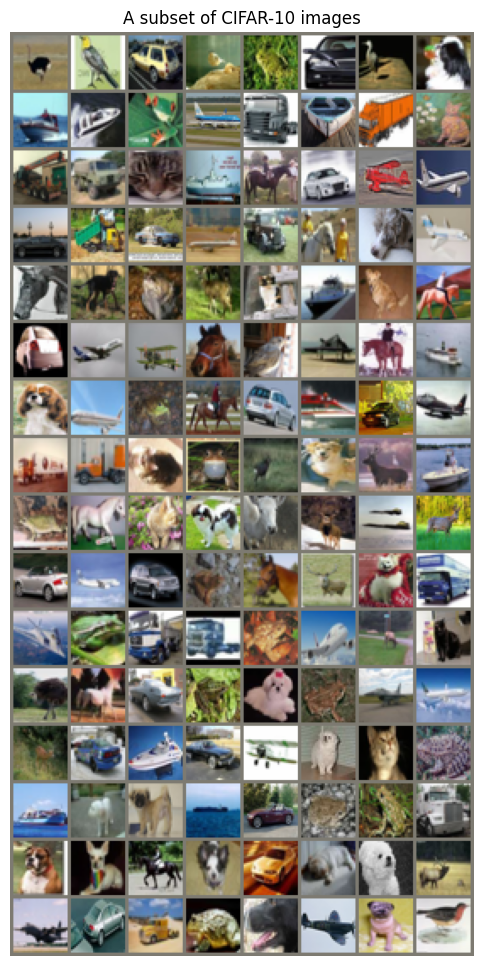

In [ ]:
show_images_cifar(trainloader_cifar)

For our MLP to read them, it must flatten a 32x32x3 images into a long 3072 pixel vector

### Question: What critical information is lost when we flatten an image?

Answer: Spatial, because MLP has no idea which pixels are next to each other. A cat's eye is no longer next to its nose. The model just sees a long, jumbled list of pixel values, making it difficult to learn about shapes, textures, and objects.

## Refactor our training code for reusability

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, model_name ="Model"):
  train_losses = []
  train_accuracies = []

  model.train()

  print(f'--- Training {model_name} for {num_epochs} epochs ---')

  for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for data, target in pbar:
      data, target = data.to(device), target.to(device)

      # Step 1: zero the gradient
      optimizer.zero_grad()

      # Step 2: forward pass
      output = model(data)

      # Step 3: Calculate the loss
      loss = criterion(output, target)

      # Step 4: Backward pass
      loss.backward()

      # Step 5: Update the weifhts
      optimizer.step()

      running_loss+= loss.item()
      _, predicted = torch.max(output.data, 1)
      total +=target.size(0)
      correct += (predicted == target).sum().item()

      pbar.set_postfix({'Loss': f'{running_loss/len(train_loader)}', 'Accuracy': f'{100*correct/total}'})

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

  print(f'---Finished training {model_name}---')
  return train_losses, train_accuracies

In [ ]:
def evaulate_model(model, test_loader):
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data) # Forward pass
      _, predicted = torch.max(output, 1)
      total+= target.size(0)
      correct += (predicted == target).sum().item()

  return 100 * correct / total


## Training MLP on CIFAR-10

In [ ]:
class MLP_CIFAR(nn.Module):
  def __init__(self):
    super(MLP_CIFAR, self).__init__()

    # define the layers
    self.fc1  = nn.Linear(32*32*3, 512)
    self.dropout = nn.Dropout(0.2)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)

  def forward(self, x):
    x = x.view(-1, 32*32*3)
    x = torch.relu(self.fc1(x))
    x = self.dropout(x)
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
model_mlp_cifar = MLP_CIFAR().to(device)
optimizer_mlp_cifar = optim.Adam(model_mlp_cifar.parameters(), lr=.001)

# now we use the functions we just created
mlp_losses, mlp_accuracies = train_model(model_mlp_cifar, trainloader_cifar, criterion, optimizer_mlp_cifar, num_epochs=5, model_name="MLP on CIFAR")

mlp_cifar_accuracy= evaulate_model(model_mlp_cifar, testloader_cifar)

print(f"Accuracy: {mlp_cifar_accuracy}")

--- Training MLP on CIFAR for 5 epochs ---


Epoch 5/5: 100%|██████████| 391/391 [00:37<00:00, 10.30it/s, Loss=1.3514737656049411, Accuracy=52.324]


---Finished training MLP on CIFAR---
Accuracy: 51.63


### A better approach - CNNs for CIFAR-10
Convolutional Neural Network (CNN). CNNs are specifically designed to "see" images by preserving their **spatial** structure

#### Core CNN Concepts
1. Convolution (nn.Conv2d): A filter (called a kernel) slides over the image and looks for local pattern like edges, corners, colors, and textures. This perserves spatial information and is very efficient due to parameter sharing (resuing the same filter across the whole image). THe output is called a **feature map**
2. Pooling (nn.MaxPool2d): This operations shrinks the feature maps, making the network faster and helping it recognize a pattern no matter where it appears in the image (**translation invariance**)

In [ ]:
# visualize a convolution
def visualize_convolution():
  # Laplacian edge detection kernel. It's a type of high-pass filter used to find edges
  # pixels that have a significantly  different internsity to their immediate neighbor

  edge_filter = torch.tensor([
      [-1, -1, -1],
      [-1, 8, -1],
      [-1, -1, -1]
  ], dtype=torch.float32)
  sample_img, _ = testset_cifar[0] # use an image from the test set

  conv_layer = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, bias=False)
  with torch.no_grad():
    conv_layer.weight[0,0] = edge_filter
    conv_layer.weight[0,1] = edge_filter
    conv_layer.weight[0,2] = edge_filter
  with torch.no_grad():
    feature_map = conv_layer(sample_img.unsqueeze(0)) # (25) - > (25,)
  fig,axes = plt.subplots(1,3, figsize=(15,5))
  img= sample_img.numpy().transpose((1,2,0))
  img = np.array(cifar_std) * img + np.array(cifar_mean)
  img = np.clip(img, 0, 1)
  axes[0].imshow(img)
  axes[1].imshow(edge_filter.numpy(), cmap='gray')
  axes[2].imshow(feature_map.squeeze().numpy(), cmap='gray')
  plt.show()

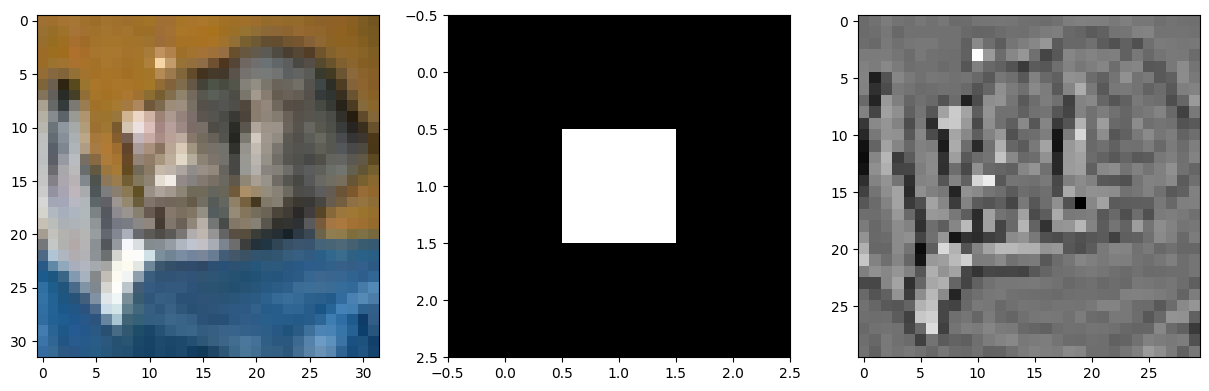

In [ ]:
visualize_convolution()

The "white square" is actually the single central pixel of the 3x3 filter, which has the value 8. The surrounding black area represents the 8 pixels that all have a value of -3.

### Build the CNN Model
Our architecture will be a stack of CONV -> RELU -> POOL blocks, followed by a classic classifier

In [ ]:
# Let's build the CNN
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()

    # The goal is to shrink image dimensions (H x W) with pooling layers before we flatten it for the classifier

    # Block 1: Input 32x32x3 -> Output 16x16x16
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1) # expanding the channels
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # reduce height and width

    # Block 2: Input: 16x16x16 -> Output 8x8x32
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    # Challenge 3: Define the third convolutional block
    # Let's add one more block to make the network deeper and shrink the feature map
    # This block will take the 8x8x32 geature map and produce a 4x4x64 one

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(4*4*64, 256)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(256, 10)

  def forward(self, x):
    # CNN Forward pass
    # pass the input through each block
    # pattern is: CONV -> RELU -> POOL

    # Block 1
    x = torch.relu(self.conv1(x))
    x = self.pool1(x)

    # Block 2
    x = torch.relu(self.conv2(x))
    x = self.pool2(x)

    # Block 3
    x = torch.relu(self.conv3(x))
    x = self.pool3(x)

    # Flatten
    x = x.view(-1, 4*4*64)

    # pass through the classifier layers
    x = torch.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [ ]:
model_cnn = SimpleCNN().to(device)
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=.001)
print(model_cnn)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


### Train and evaluate the CNN

In [ ]:
cnn_losses, cnn_accuracies = train_model(model_cnn, trainloader_cifar, criterion, optimizer_cnn, num_epochs=5, model_name="CNN on CIFAR")
cnn_cifar_accuracy = evaulate_model(model_cnn, testloader_cifar)
print(f'Accuracy of the CNN on CIFAR-10: {cnn_cifar_accuracy:.2f}%')

--- Training CNN on CIFAR for 5 epochs ---


Epoch 5/5: 100%|██████████| 391/391 [01:17<00:00,  5.08it/s, Loss=0.9375040508292215, Accuracy=66.882]


---Finished training CNN on CIFAR---
Accuracy of the CNN on CIFAR-10: 69.81%


In [ ]:
# get number of parameters
mlp_params = sum(p.numel() for p in model_mlp_cifar.parameters())
cnn_params = sum(p.numel() for p in model_cnn.parameters())

print(f"Test accuracy (MLP): {mlp_cifar_accuracy:.2f}%")
print(f"Test accuracy (CNN): {cnn_cifar_accuracy:.2f}%")

print(f"Number of parameters in MLP: {mlp_params}")
print(f"Number of parameters in CNN: {cnn_params}")

Test accuracy (MLP): 51.63%
Test accuracy (CNN): 69.81%
Number of parameters in MLP: 1707274
Number of parameters in CNN: 288554


### What did the CNN learn? Visualize what the network "sees"

In [ ]:
# Visualize layer 1 filter (edge, color detectors)

# the first layer's filter looks at the raw input image (RGB). They elarn to detect very simple things like colors, edges, and gradients

def visualize_conv1_filters(model):
  filters = model.conv1.weight.data.cpu()

  # set up plot
  fig, axes = plt.subplots(2,8,figsize=(12,3)) # 2 rows, 8 columns for our 16 filters
  axes = axes.ravel()

  for i in range(filters.shape[0]):
    #PyTorch stores filter as (out_channels, H, W). We need (H, W, out_channels) for plotting
    filter_img = filters[i].permute(1,2,0)

    #normalize filter values between 0 and 1
    filter_img = (filter_img - filter_img.min()) / (filter_img.max() - filter_img.min())

    axes[i].imshow(filter_img)
    axes[i].set_title(f'Filter {i}', fontsize=8)
    axes[i].axis('off')

  plt.suptitle("Filters Learned by Conv1", fontsize = 16)
  plt.tight_layout(rect=[0,0,1,.95])
  plt.show()

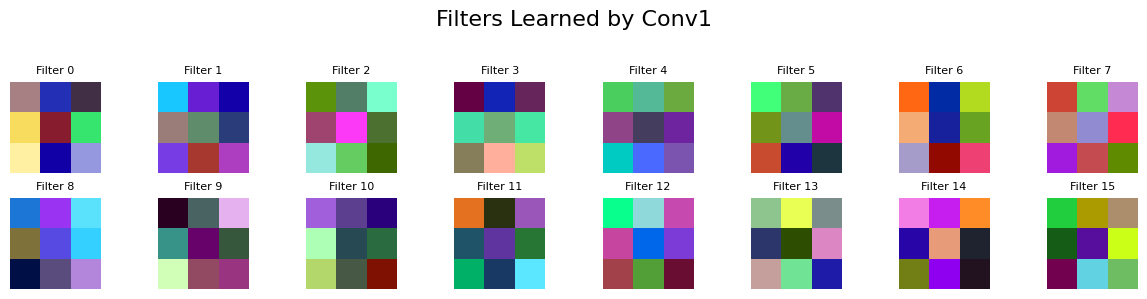

In [ ]:
visualize_conv1_filters(model_cnn)

In [ ]:
def visualize_deeper_filters(model, layer_name):
  if layer_name == 'conv2':
    filters = model.conv2.weight.data.cpu()
    num_rows = 4
  elif layer_name == 'conv3':
    filters = model.conv3.weight.data.cpu()
    num_rows = 8
  else:
    return

  fig, axes = plt.subplots(num_rows, 8, figsize=(12,1.5*num_rows))
  axes = axes.ravel()

  for i in range(filters.shape[0]):
    # average across the input channels to get a single grayscale image
    filter_img = filters[i].mean(dim=0)

    axes[i].imshow(filter_img, cmap='gray')
    axes[i].set_title(f'Filter {i}', fontsize=8)
    axes[i].axis('off')

  plt.suptitle(f'Filters learned by {layer_name}', fontsize=16)
  plt.tight_layout(rect=[0,0,1,.96])
  plt.show()

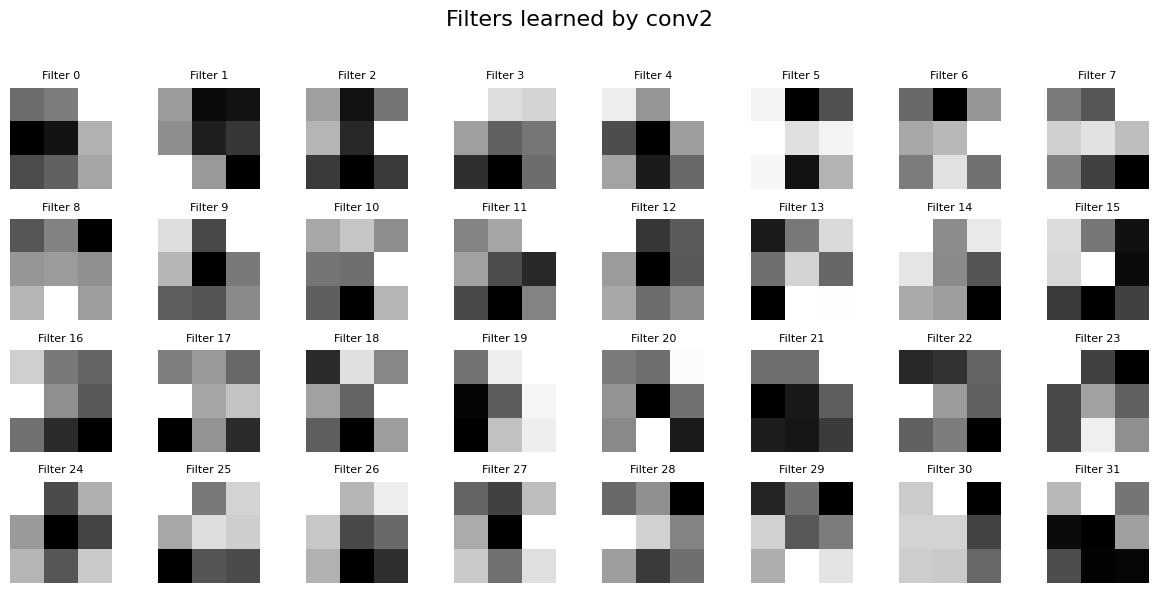

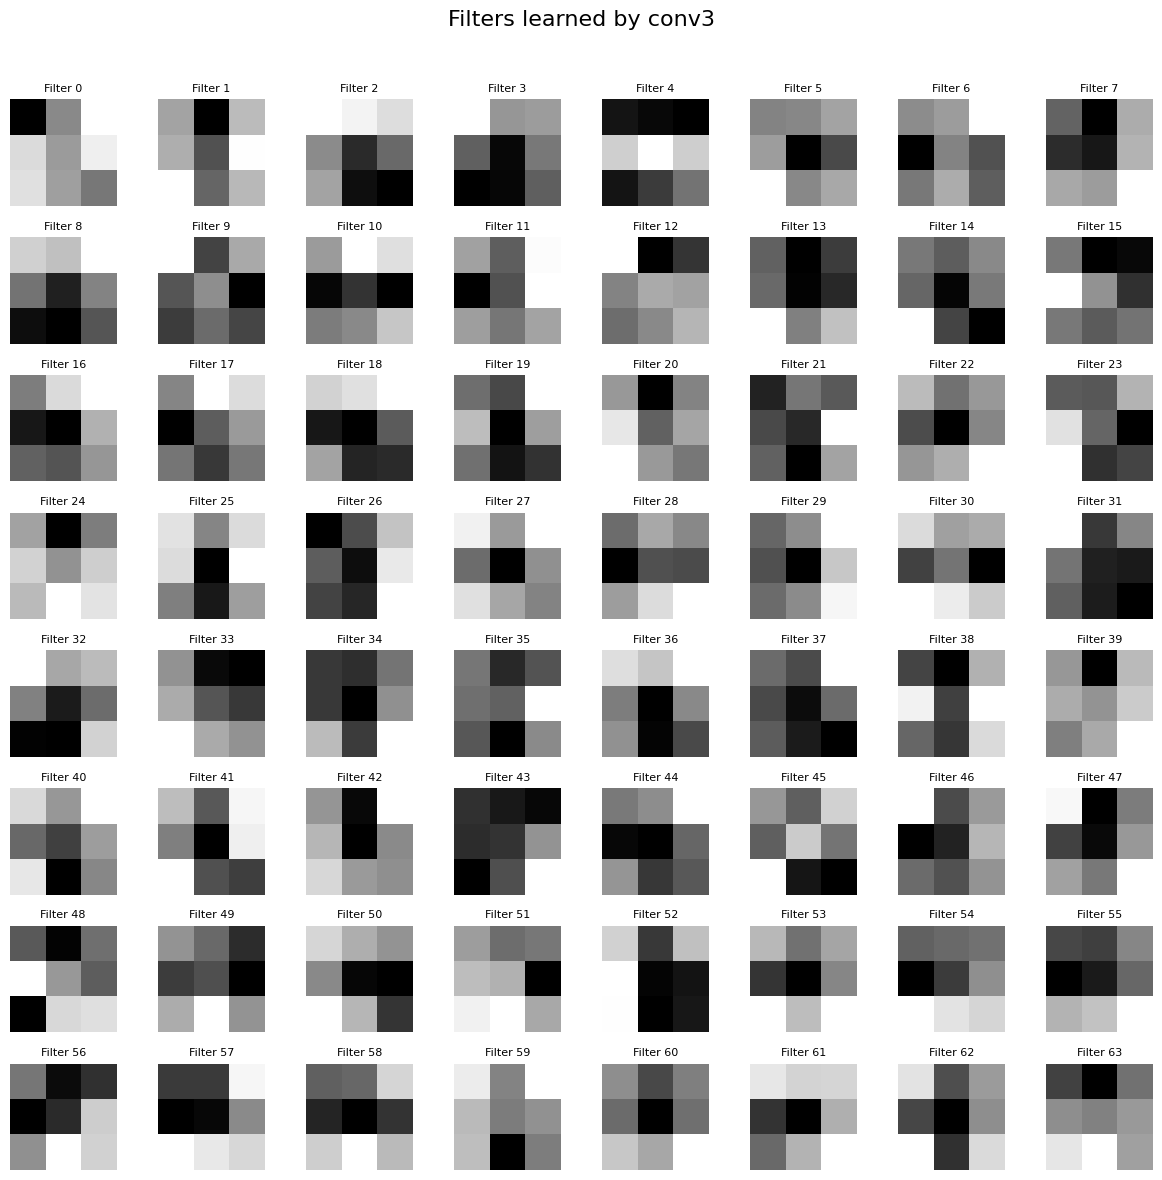

In [ ]:
visualize_deeper_filters(model_cnn, 'conv2')
visualize_deeper_filters(model_cnn, 'conv3')

### Conceptual Challenge

1. Spatial relationships
- MLP: Flattens the image, losing **spatial** information
- CNN: Preserves the 2d structure through **convolution**.

2. Parameter Efficiency
- MLP: A large number of parameters (fully connected).
- CNN: Fewer parameters due to **parameter sharing**.

3. Features
- MLP: Must learn all features at once in large, undifferentiated layers
- CNN: Builds features **layer by layer** (Layer 1 finds edges -> Layer 2 combines edges into shapes -> Deeper layers combine shapes into objects)



### Homework challenges
1. Architecture
- Add another hidden layer to the MLP_CIFAR. Does performance change?
- Add another `conv -> pool` block to the SimpleCNN. Does accuracy improve? Watch for overfitting

2. Hyperparameter tuning
- Change the learning rate in the `Adam` optmizer. How does this affect training speed and final accuracy?
- Try a different optimizer, e.g. `optim.SGD`

3. Research Questions?
- What is **Transfer Learning**? How could we use a model pre-trained on a giant dataset (like ImageNet) to get even better results on CIFAR-10?
- What is **Batch Normalization** (`nn.BatchNorm2d`) and where would you add it in our `SimpleCNN`